### Import required libraries

In [2]:

import pymysql
from cryptography.fernet import Fernet
import json
from collections import namedtuple
import time
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine 
from sklearn import model_selection
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

%matplotlib inline

### Increase the size of the screen

In [4]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Decrypt Credentials and Connect to Database

In [6]:
#Uncode the secret license file
#Uncode the secret license file
def unencrypt():
    try:
        key = b'IXx5rHfP15FqP4ahx2pwcud-XmcBzU553Ri6p-nVhnc=' #Fernet.generate_key()
        cipher_suite = Fernet(key)
        with open('/usr/local/etc/musicmood_bytes.bin', 'rb') as file_object:
            for line in file_object:
                encryptedpwd = line
        uncipher_text = (cipher_suite.decrypt(encryptedpwd))
        plain_text_encryptedpassword = bytes(uncipher_text).decode("utf-8") #convert to string
        x = json.loads(plain_text_encryptedpassword, object_hook=lambda d: namedtuple('X', d.keys())(*d.values()))
        return x
    except Exception as e:
        print(str(e))
        return "Error" 

#Setup the database connection
credentials = unencrypt()
user_id = credentials.user
user_password = credentials.password
dbname = credentials.dbname
server = credentials.server
conn = pymysql.connect(server,user_id,user_password,dbname)

### Load the normalized table

In [8]:
start_time = time.time()
df = pd.read_sql('SELECT * FROM songs_instance_clean', con = conn)
print('--- %s seconds ---' % (time.time() - start_time))
    
df.drop(['index'],axis=1, inplace=True)
df.head(15)

df.describe()

--- 0.7990579605102539 seconds ---


,decade,duration,key_song,loudness,mode,tempo,time_signature,words_song_u,words_song,words_song_r,words_genre_u,words_genre,words_genre_r,words_second,speed_general,artist_familiarity,artist_hotttnesss,gnr_Blues,gnr_Country,gnr_Folk,gnr_Funk,gnr_House Electronic Trance,gnr_Jazz,gnr_Latin,gnr_Metal,gnr_Pop,gnr_Pop Standards,gnr_Punk,gnr_Rap Hip Hop,gnr_Rhythm and Blues,gnr_Rock,gnr_Rock and Roll,gnr_Ska Reggae Dancehall,is_top40
count,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000
mean,1982.074255,237.804162,5.315300,-9.215717,0.709914,124.189140,3.626030,87.326694,257.966896,0.359932,87.425214,259.429376,0.341456,1.415320,2.495390,0.670480,0.479963,0.006691,0.067646,0.026275,0.000326,0.029621,0.022358,0.006528,0.067156,0.137087,0.019502,0.002285,0.045777,0.049857,0.368666,0.031089,0.002856,0.379111
std,15.057890,90.091553,3.588874,3.902081,0.453820,31.397375,1.114364,29.920948,108.391421,0.098588,21.491572,73.601847,0.035276,0.375069,0.561065,0.124608,0.116631,0.081529,0.251147,0.159958,0.018064,0.169545,0.147852,0.080535,0.250303,0.343953,0.138288,0.047747,0.209010,0.217659,0.482463,0.173566,0.053367,0.485185
min,1950.000000,2.000000,0.000000,-37.695999,0.000000,0.000000,0.000000,1.000000,1.000000,0.036629,67.000000,172.000000,0.260000,0.302600,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1970.000000,181.000000,2.000000,-11.644000,0.000000,100.880500,4.000000,77.000000,216.000000,0.336743,80.000000,229.000000,0.310000,1.398200,2.000000,0.589133,0.400982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1980.000000,227.000000,5.000000,-8.686000,1.000000,121.603996,4.000000,87.326694,257.966896,0.338519,80.000000,229.000000,0.350000,1.527000,3.000000,0.671095,0.463155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2000.000000,272.000000,9.000000,-6.260500,1.000000,141.956000,4.000000,87.326694,257.966896,0.376068,86.000000,265.000000,0.350000,1.527000,3.000000,0.761731,0.540461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2010.000000,1241.000000,11.000000,-0.278000,1.000000,249.559006,7.000000,480.000000,2539.000000,1.000000,178.000000,530.000000,0.420000,2.115800,3.000000,1.000000,1.082500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Visualize only important features 

In [9]:
songs = df[['decade', 'duration', 'key_song', 'loudness', 'mode', 'tempo', 'time_signature', \
            'words_song_u','words_song', 'words_song_r', 'words_genre_u','words_genre','words_genre_r','words_second',\
            'speed_general', 'artist_familiarity', 'artist_hotttnesss', \
            'gnr_Metal','is_top40']]

### Correlation Matrix Plot

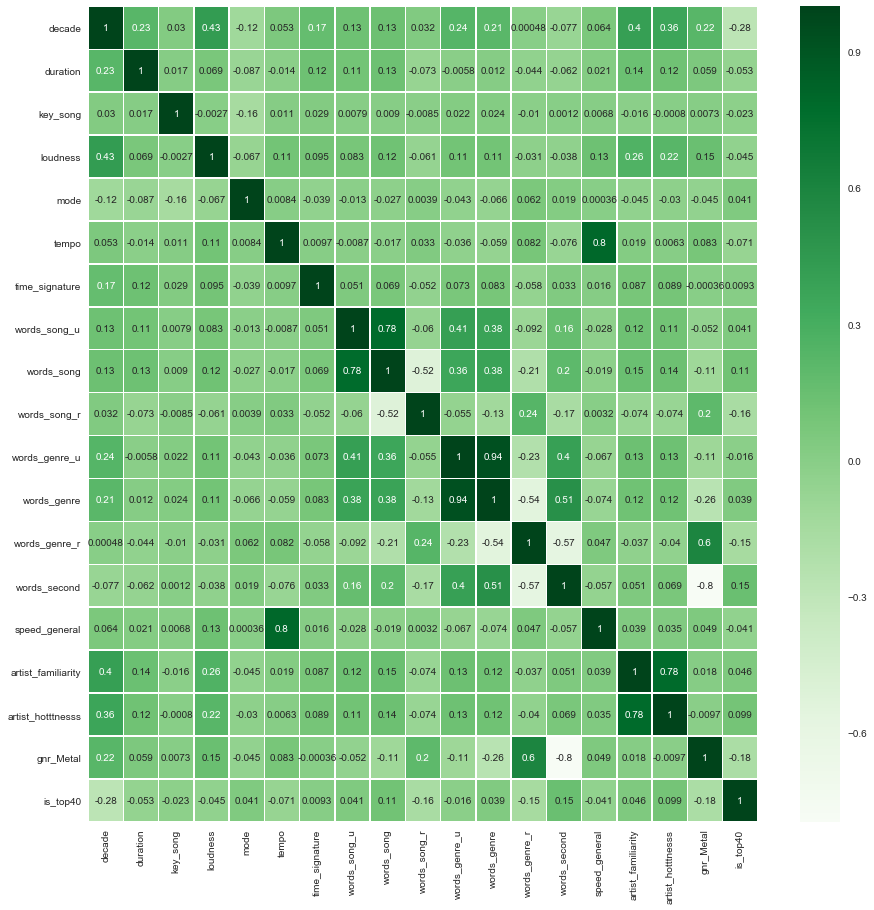

In [13]:
import seaborn as sns
corr = songs.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
ax=sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, linewidths=.5, cmap="Greens")
plt.show()

### Scatterplot

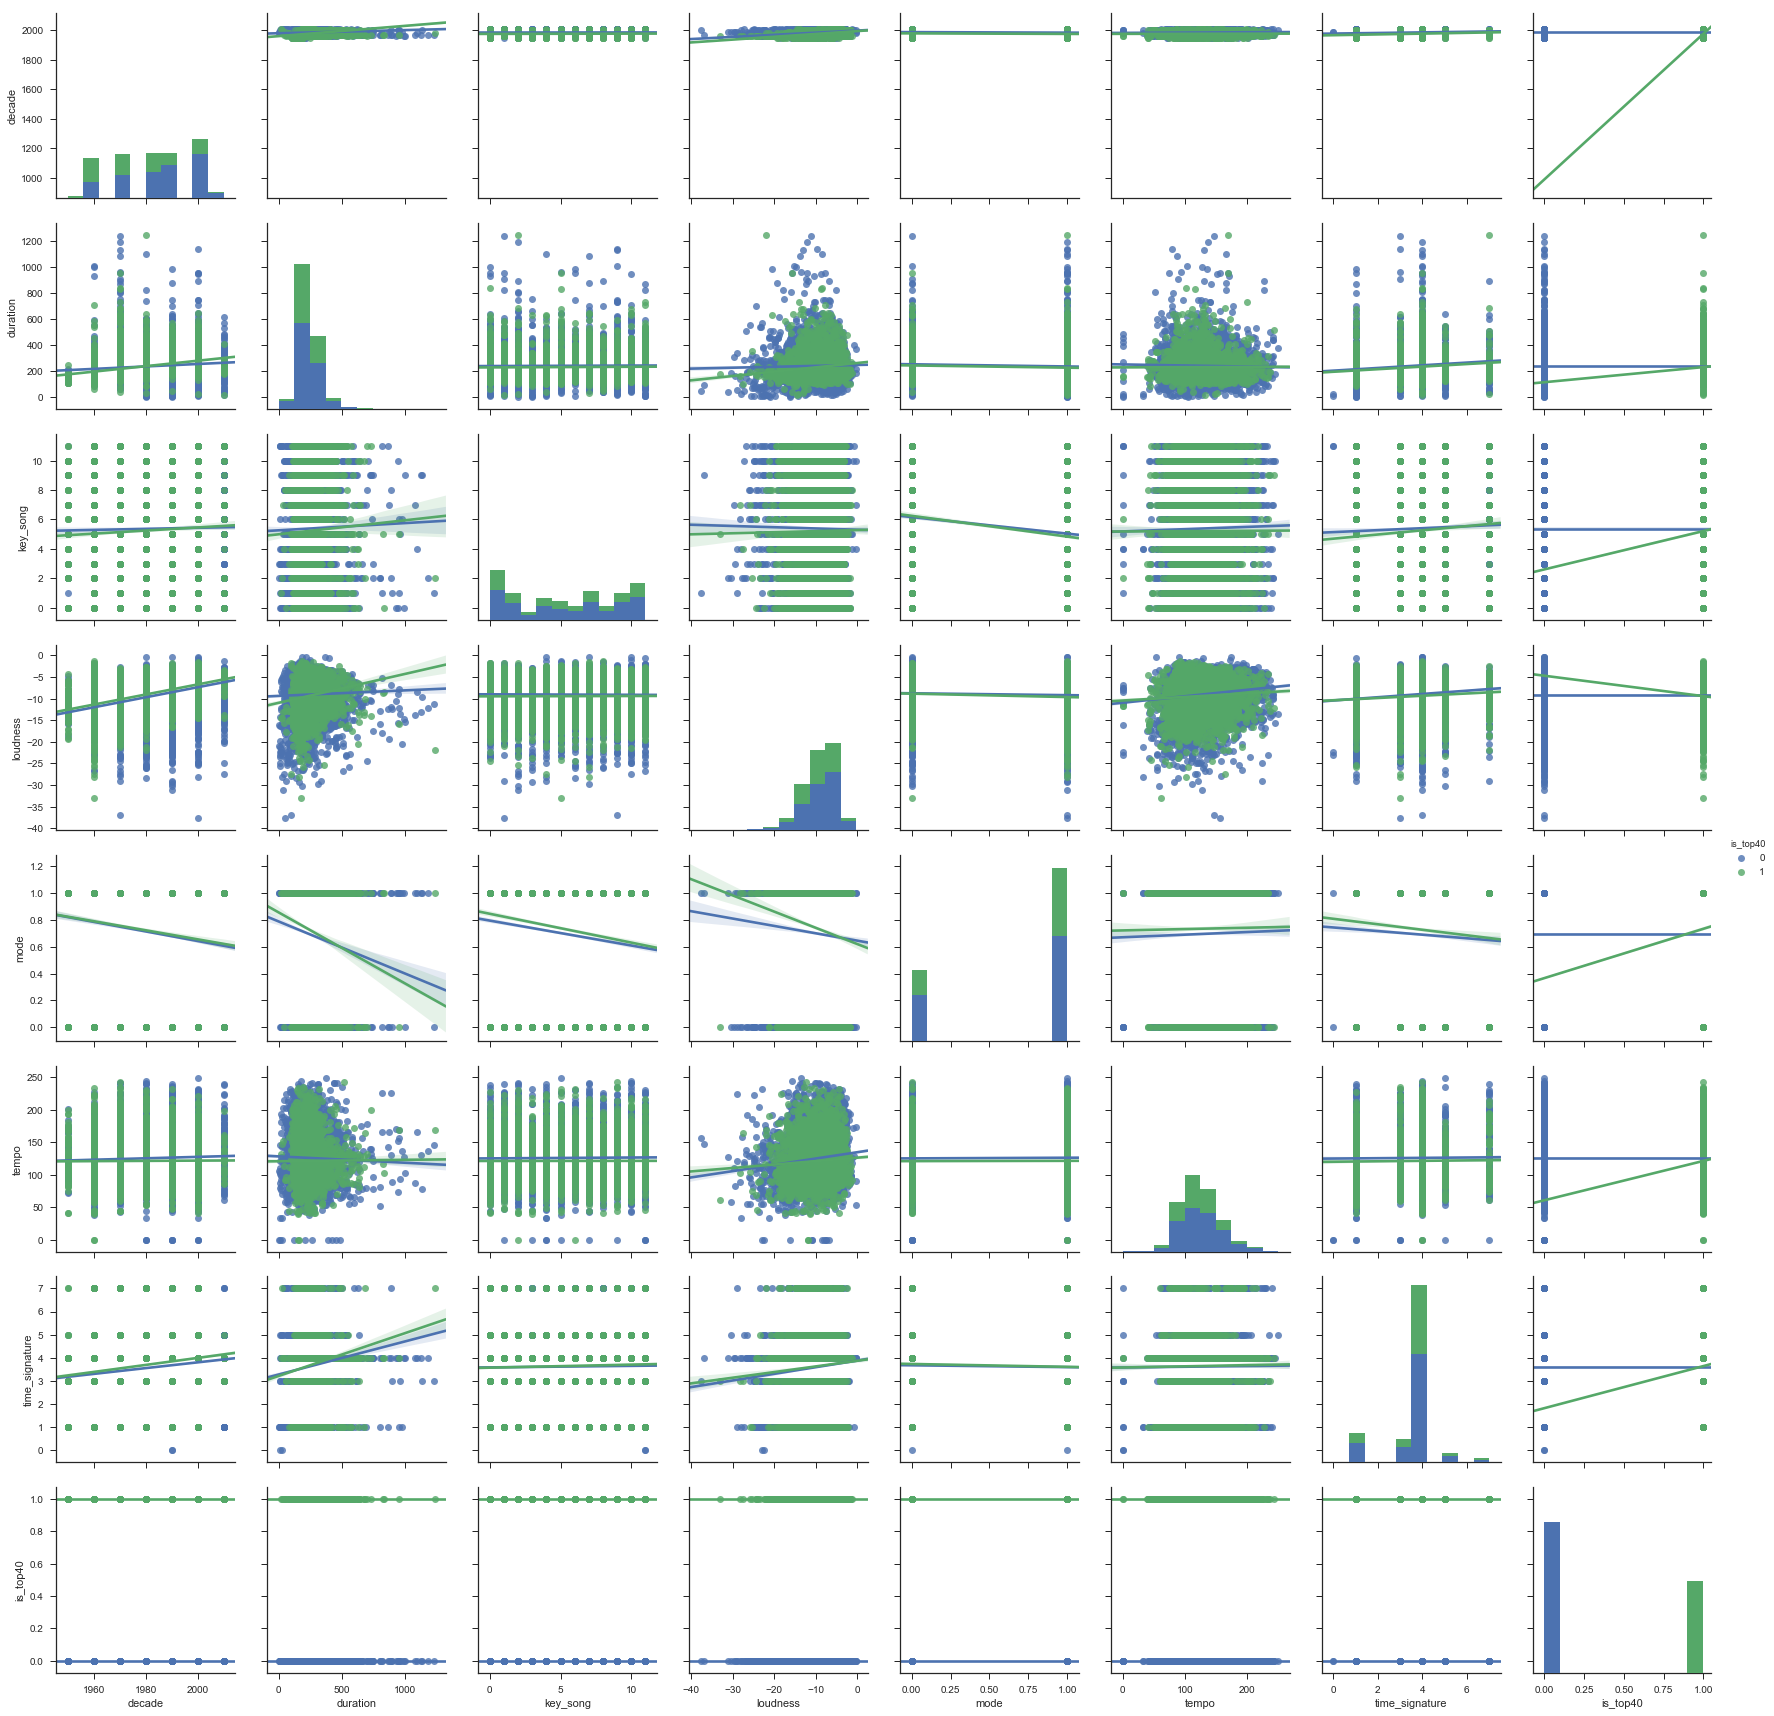

In [46]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
g = sns.pairplot(songs, size=3, hue='is_top40', vars=['decade', 'duration', 'key_song', 'loudness', 'mode', 'tempo', \
                                      'time_signature','is_top40'], kind="reg")

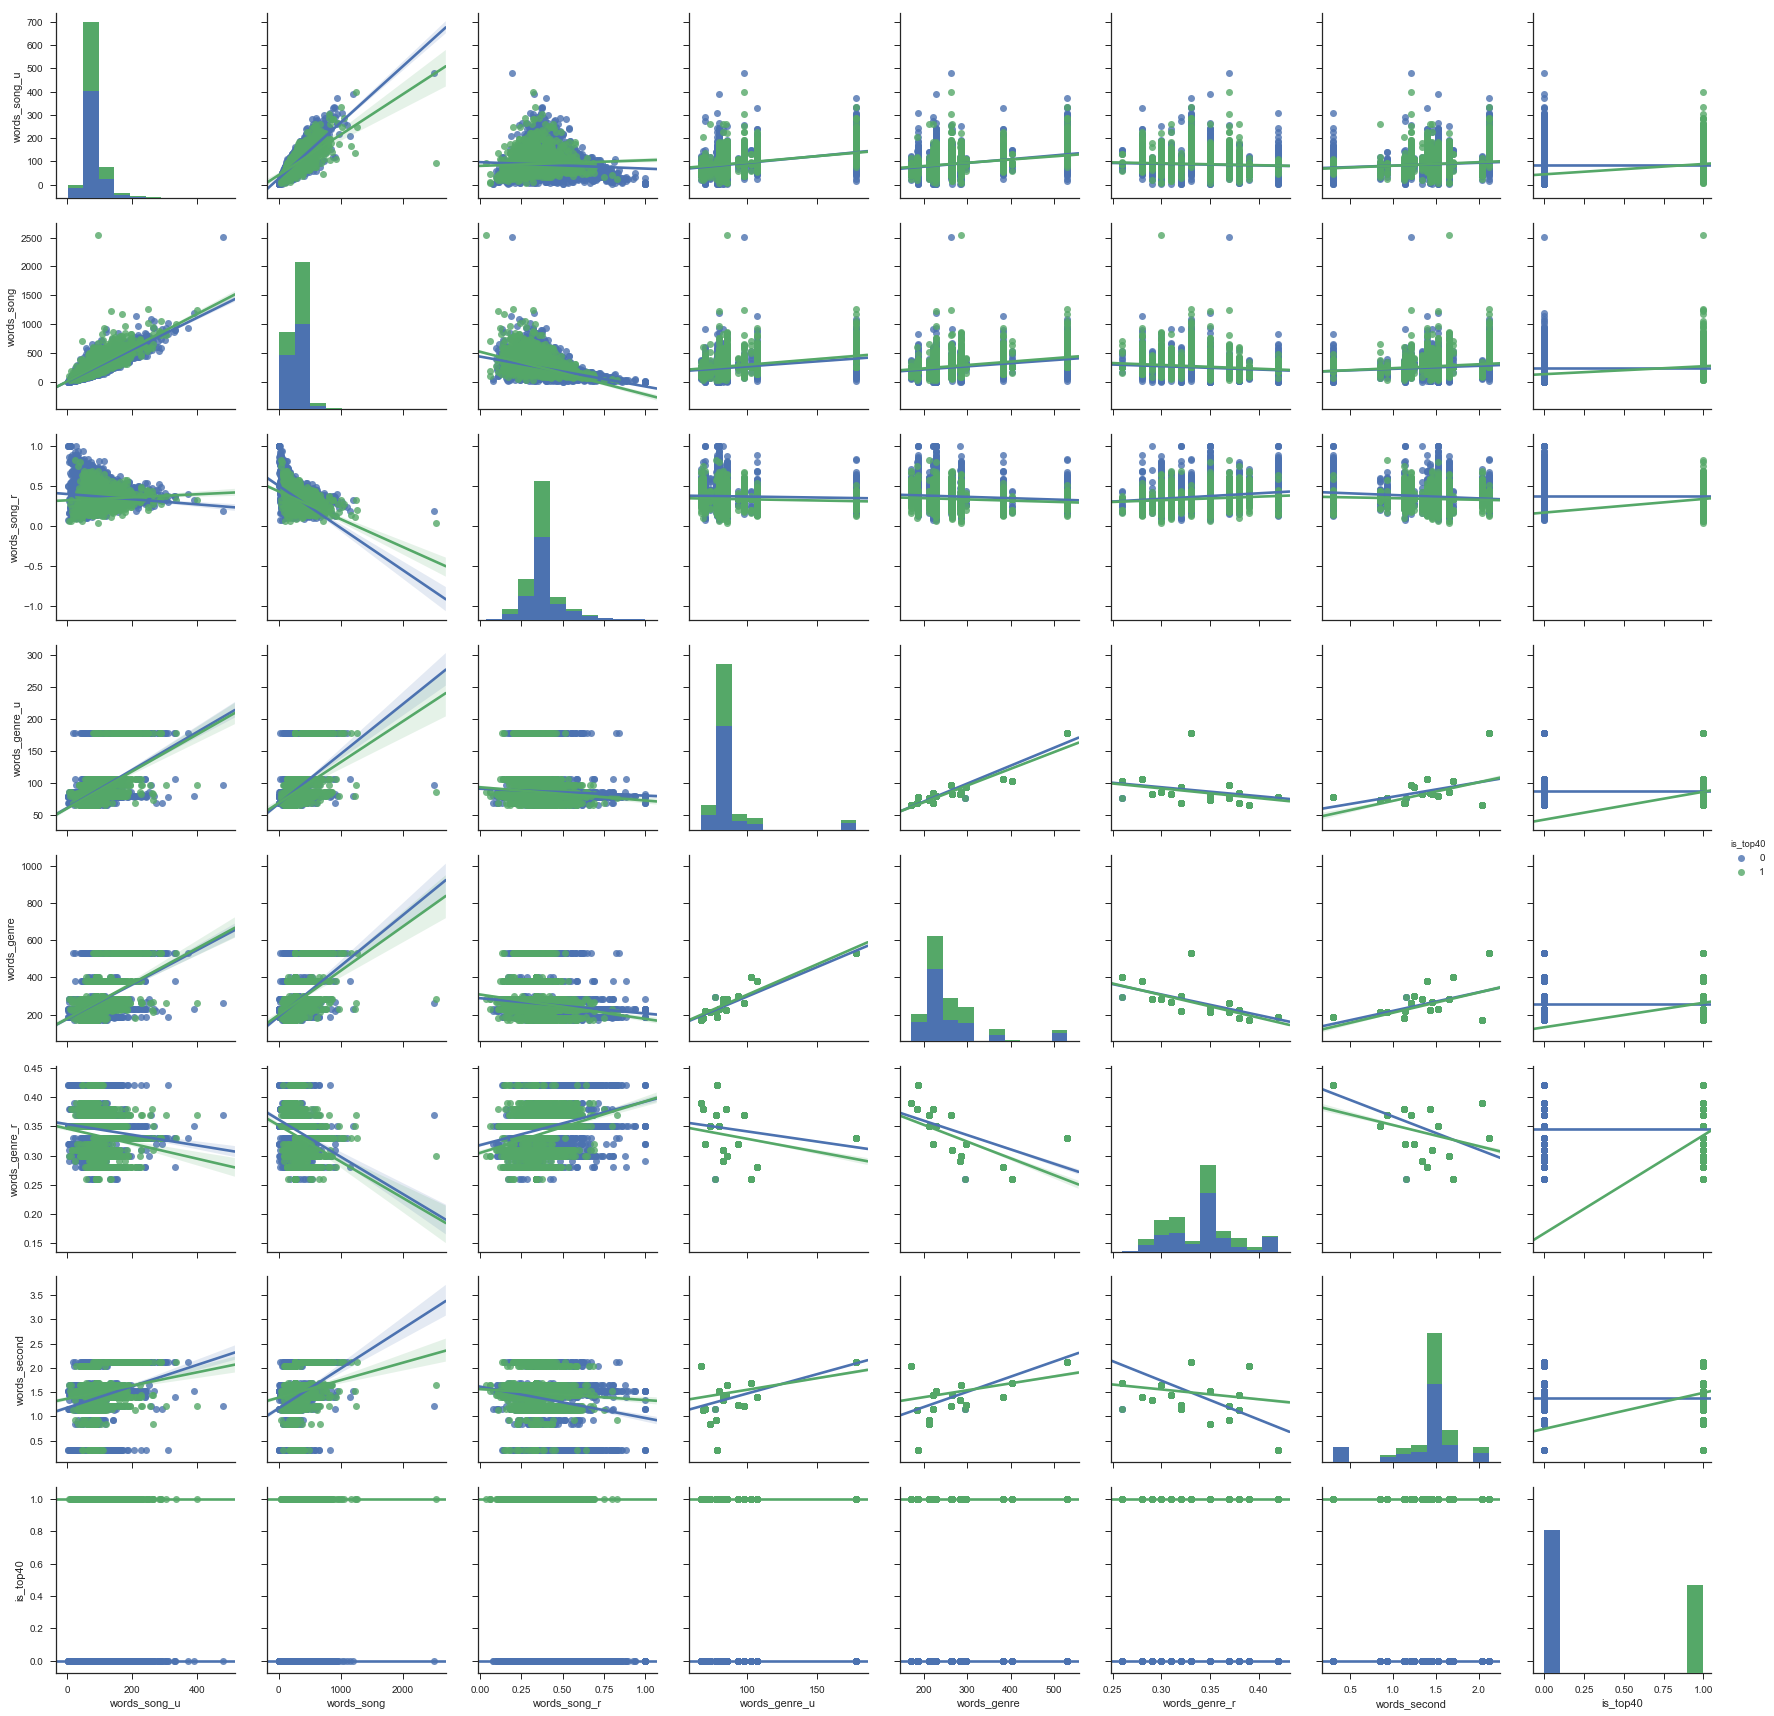

In [45]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
g = sns.pairplot(songs, size=3, hue='is_top40', vars=['words_song_u','words_song', 'words_song_r', 'words_genre_u','words_genre',\
                                      'words_genre_r','words_second','is_top40'], kind="reg")

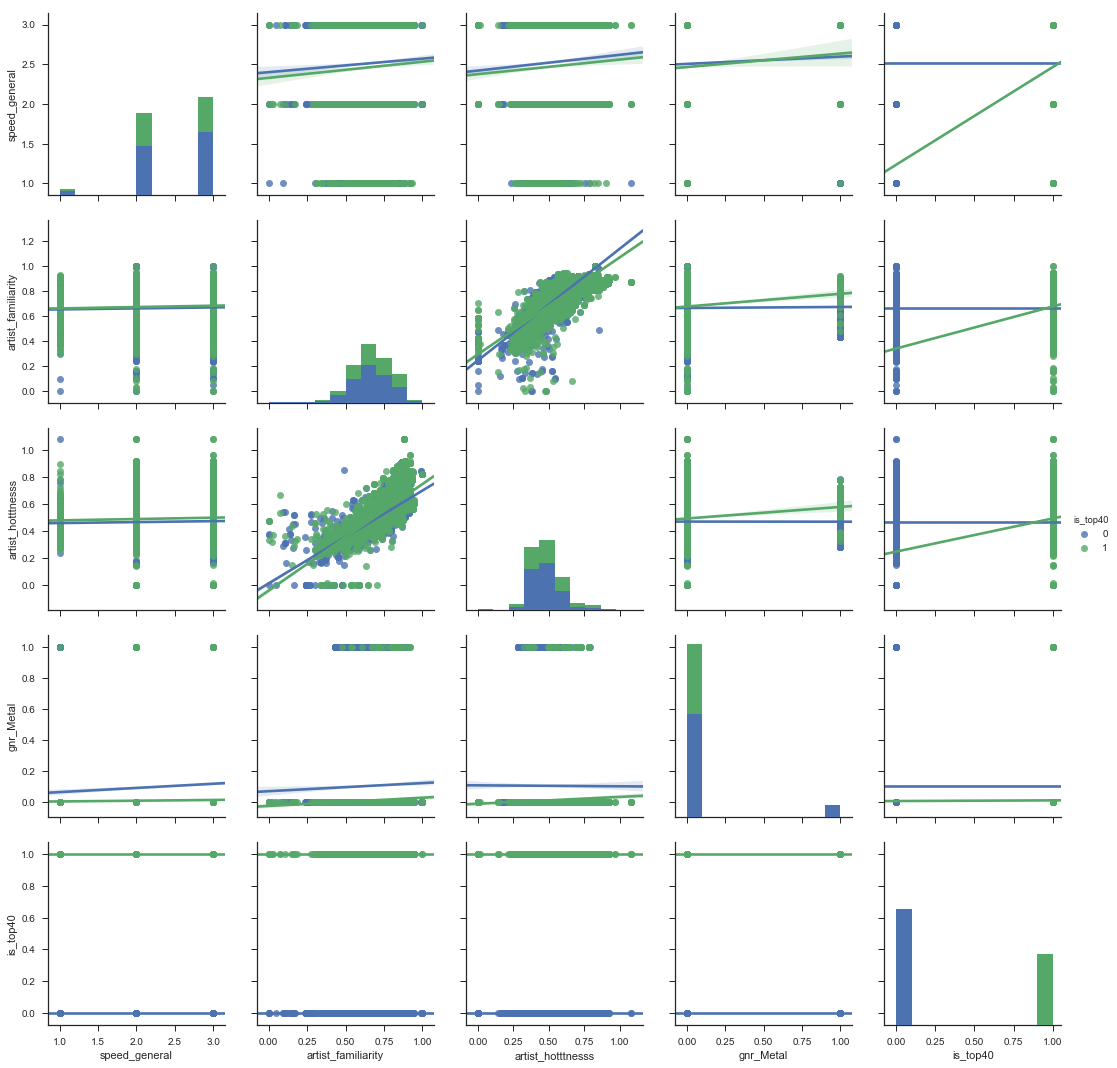

In [44]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
g = sns.pairplot(songs,hue='is_top40', size=3, vars=['speed_general', 'artist_familiarity', 'artist_hotttnesss', \
            'gnr_Metal','is_top40'], kind="reg")

### Scatter Matrix

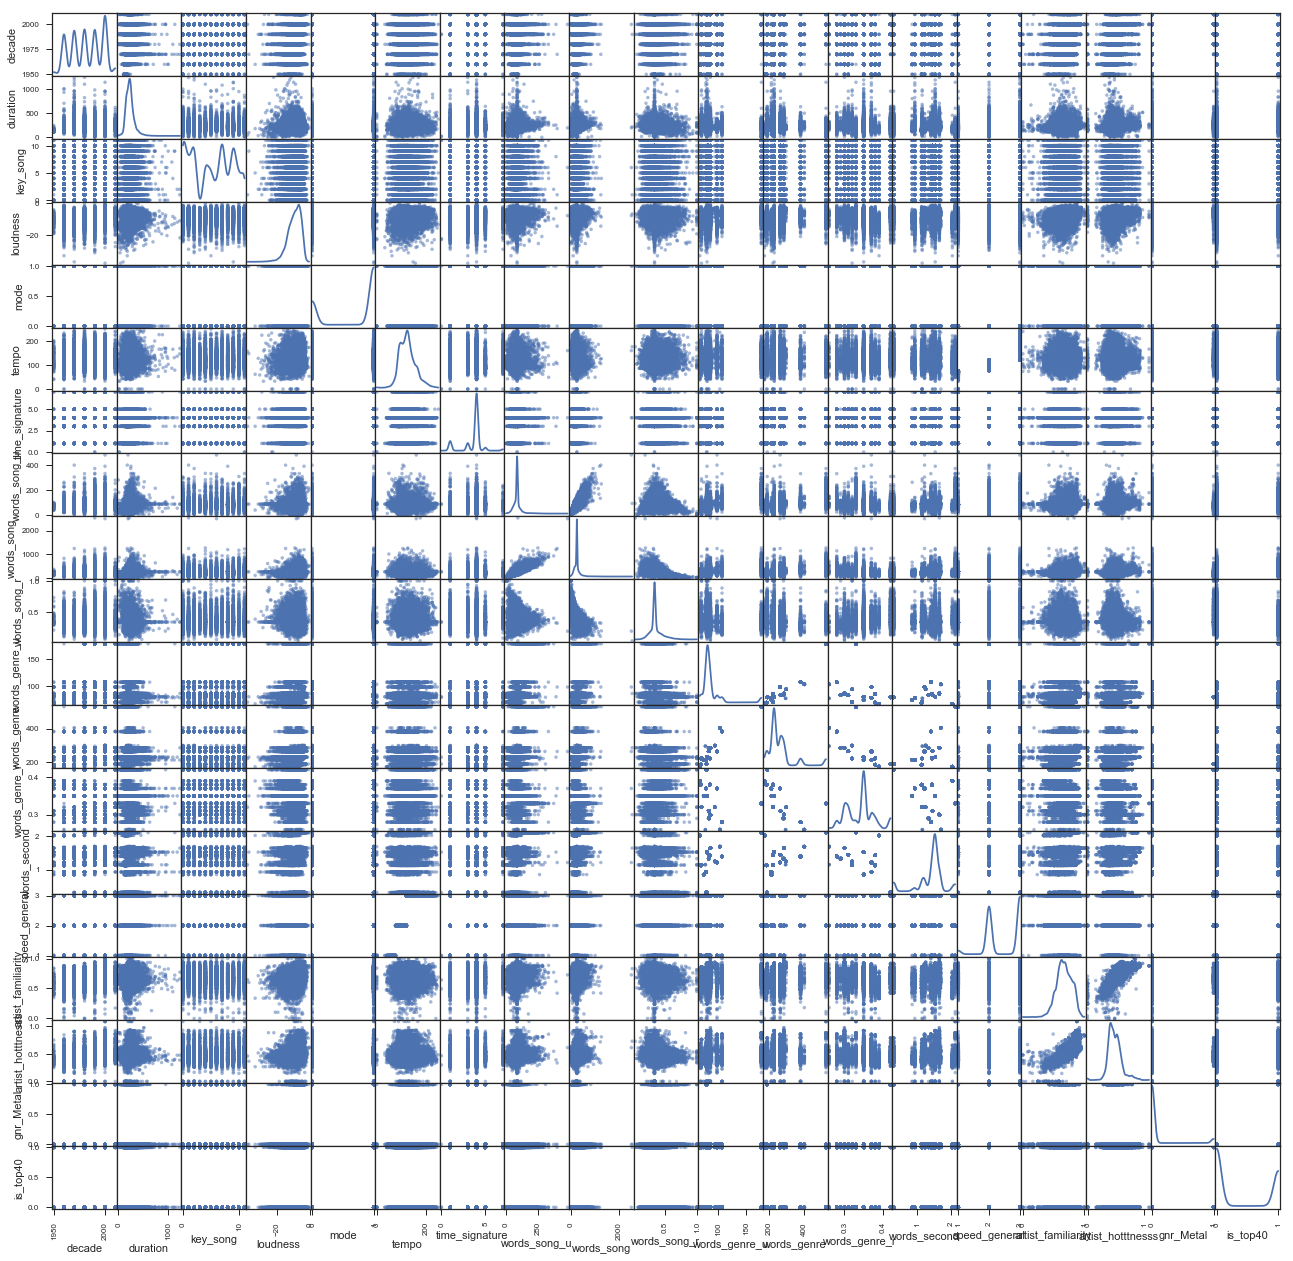

In [21]:
# Create a scatter matrix of the dataframe features
from pandas.plotting import scatter_matrix
scatter_matrix(songs, alpha=0.5, figsize=(22, 22), diagonal='kde')
plt.show()

### Kernel Density Estimation Plots

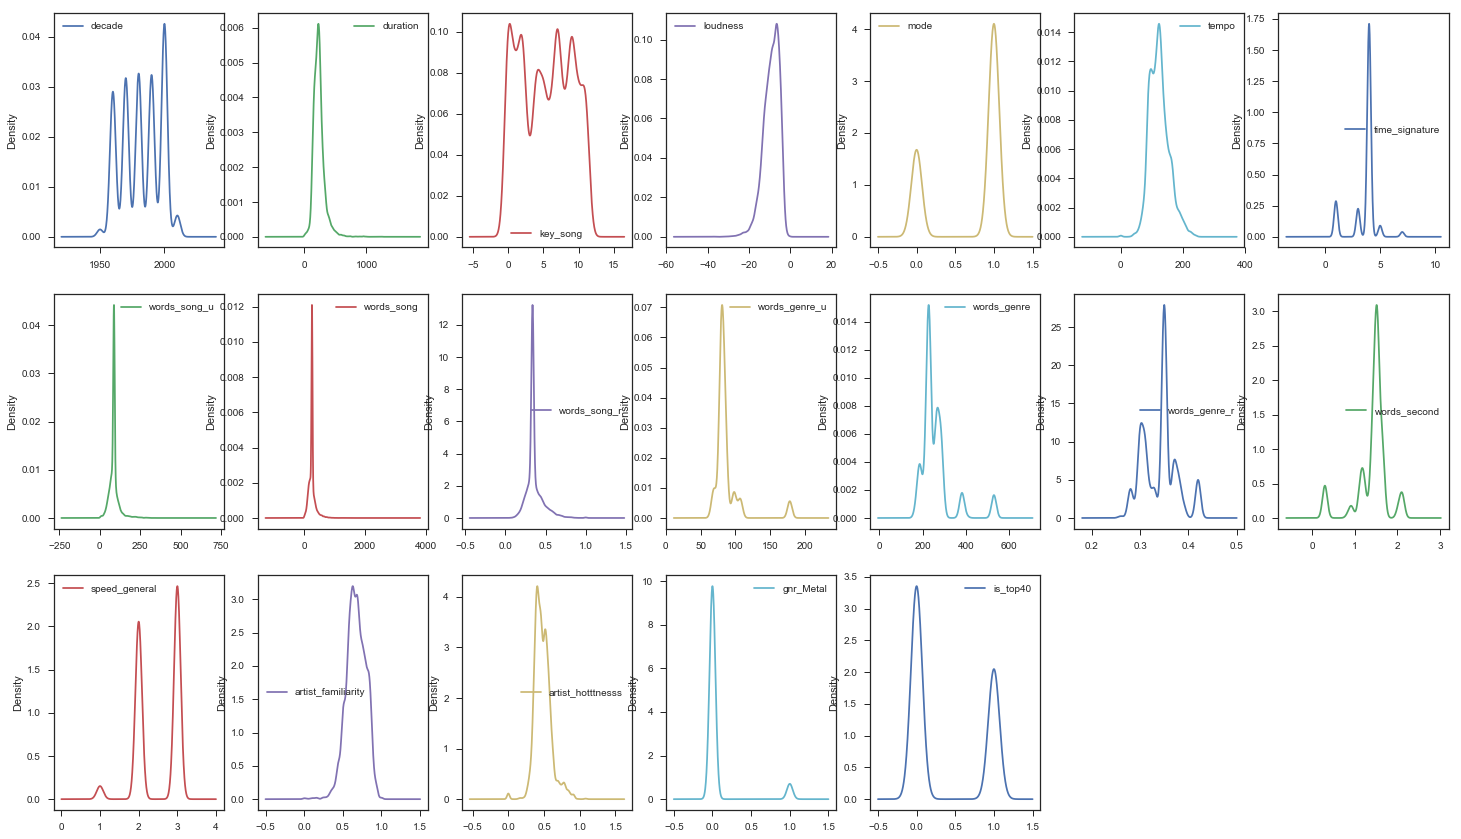

In [26]:
songs.plot(kind='kde', subplots=True, layout=(5,7), sharex=False, sharey=False, figsize=(25,25))
plt.show()

### Box Plots 

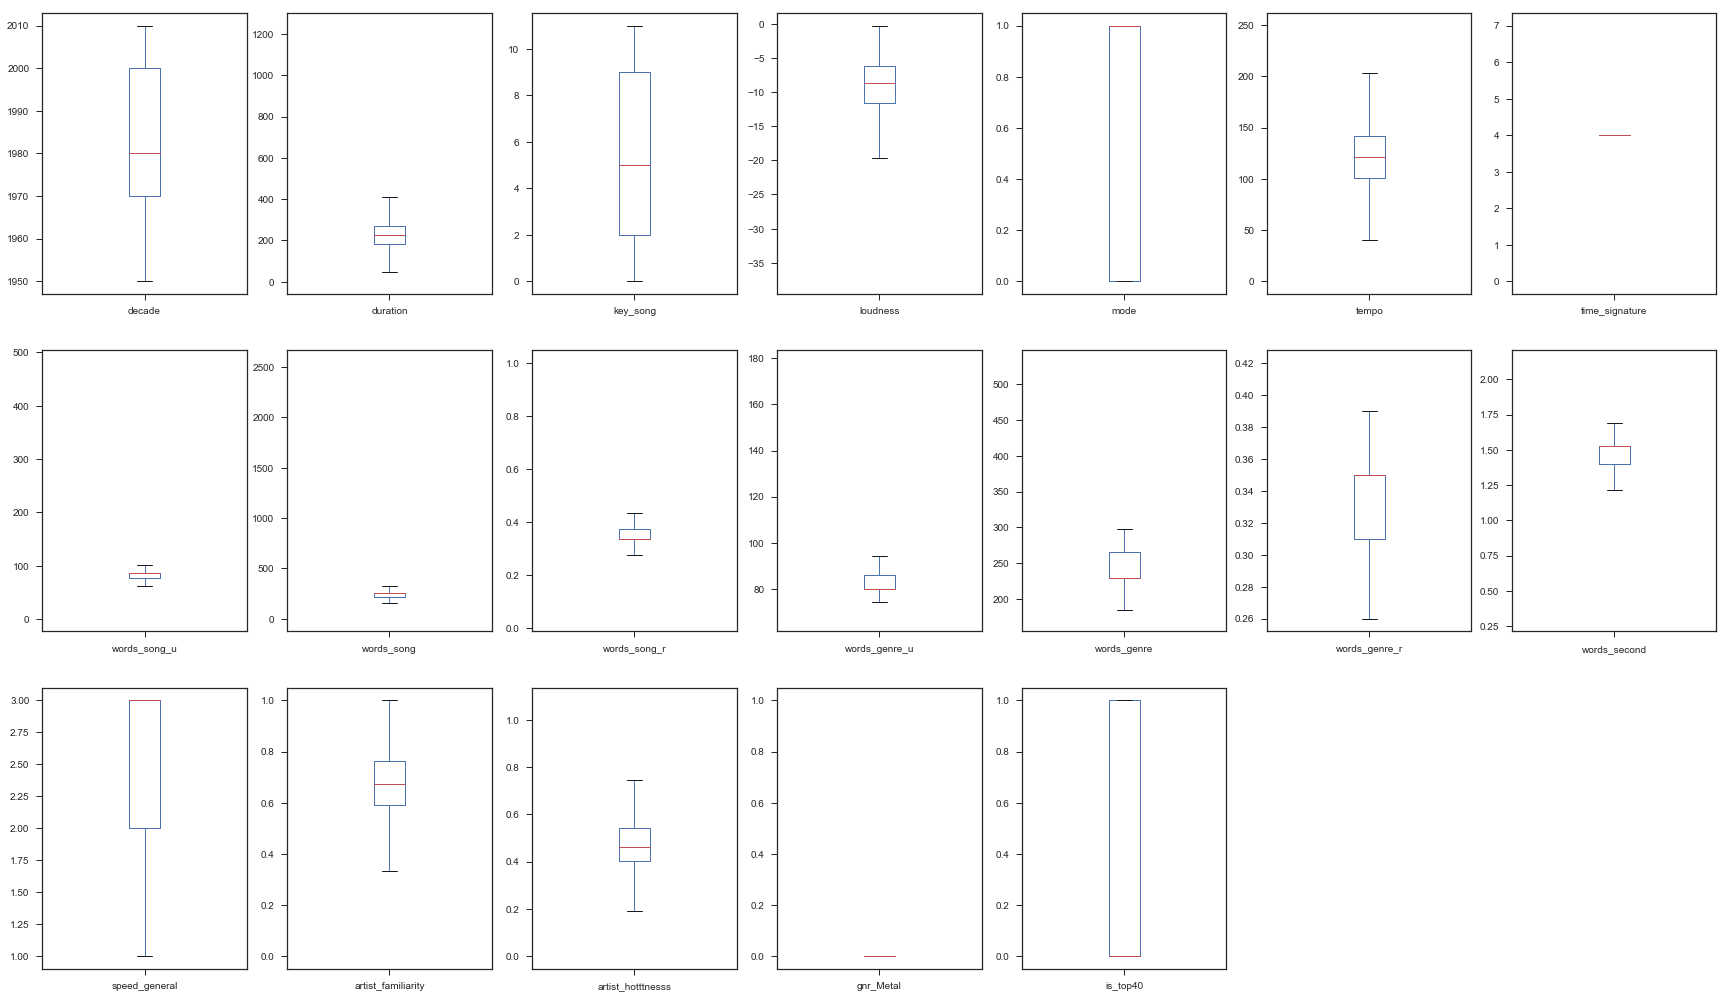

In [25]:
songs.plot(kind='box', subplots=True, layout=(5,7), sharex=False, sharey=False, figsize=(30,30))
plt.show()

### Parallel Coordinates

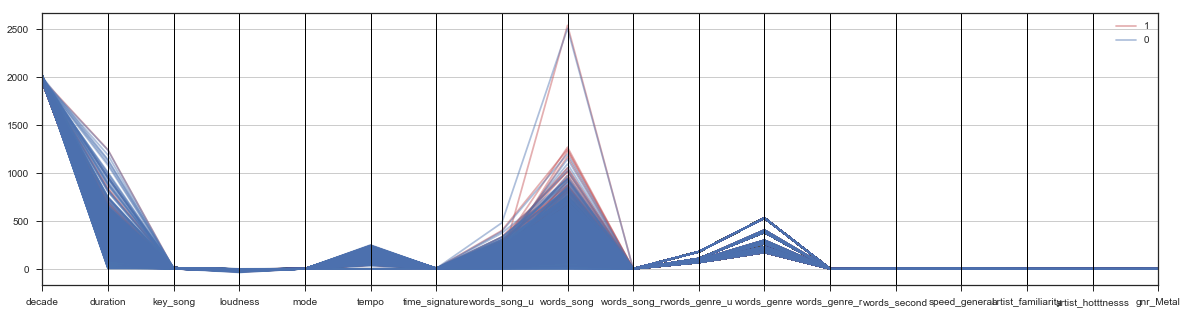

In [47]:
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(20,5))
#dataset = df[['loudness','mode','duration','time_signature','tempo','key_song','is_top40']]
parallel_coordinates(songs, 'is_top40',color=['r','b'], alpha=0.45)
plt.show()

### Rad Viz

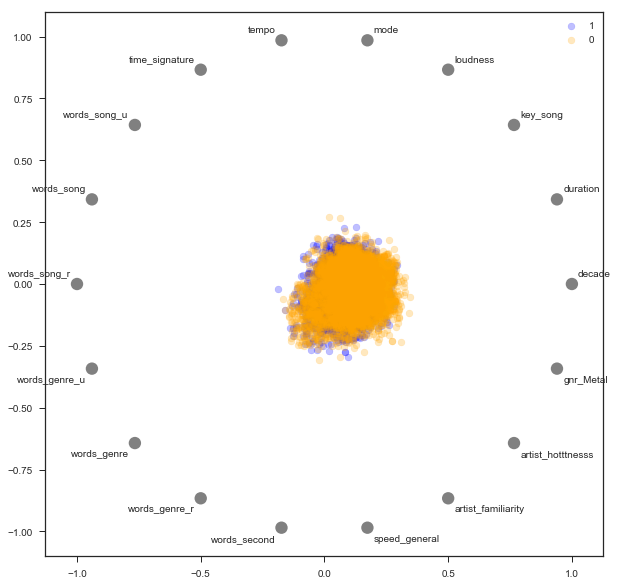

In [36]:
from pandas.plotting import radviz
plt.figure(figsize=(10,10))
radviz(songs, 'is_top40',color=['blue','orange'], alpha=0.25)
plt.show()

# Initial Model Comparison

### Split-Out validation dataset

In [48]:
array = songs.values
X = array[:,0:-1]
Y = array[:,-1] #is_top40
    
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

  ### Test options and evaluation metric

In [49]:
seed = 7
scoring = 'accuracy'

### Selected Algorithms

In [50]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RFC', RandomForestClassifier(n_estimators=10)))

### Initial Evaluation Each Model in Turn

In [51]:
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=12, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)'% (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.632599 (0.016870)
LDA: 0.683803 (0.014520)
KNN: 0.638821 (0.019407)
CART: 0.665239 (0.016592)
NB: 0.545696 (0.016915)
SVM: 0.622501 (0.015365)
RFC: 0.695532 (0.009010)


### Compare Algorithms

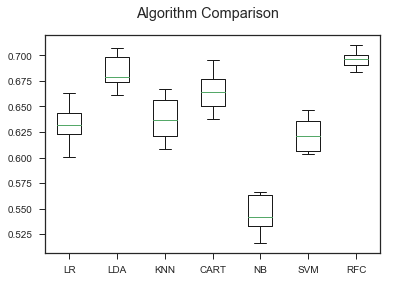

In [57]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Applying the Visualization to the Models

LR
0.6389228886168911
[[1360  161]
 [ 724  206]]


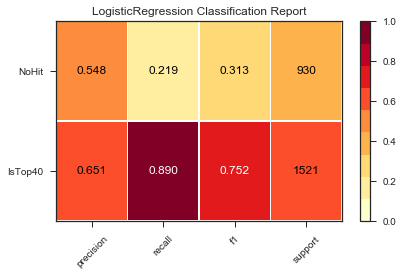

LDA
0.6752345981232151
[[1207  314]
 [ 482  448]]


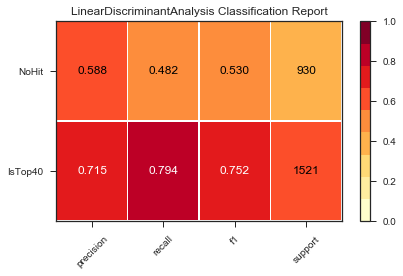

KNN
0.6650346797225622
[[1113  408]
 [ 413  517]]


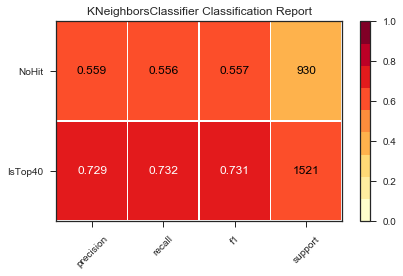

CART
0.6503467972256222
[[1082  439]
 [ 418  512]]


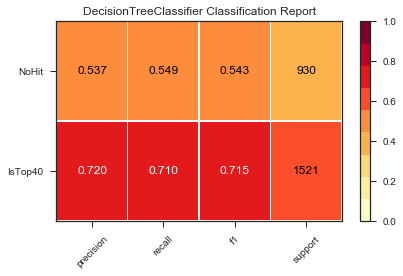

NB
0.536515707874337
[[ 493 1028]
 [ 108  822]]


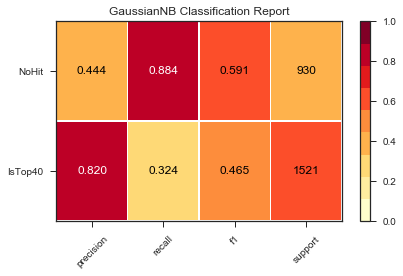

SVM
0.6242350061199511
[[1507   14]
 [ 907   23]]


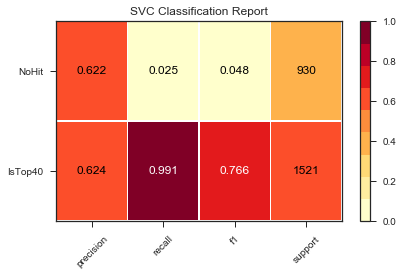

RFC
0.6870665034679723
[[1237  284]
 [ 483  447]]


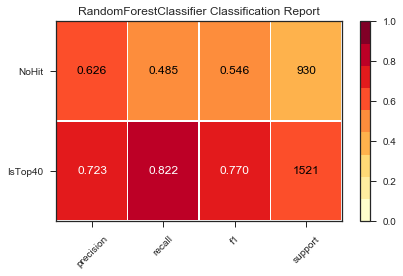

In [56]:
from yellowbrick.classifier import ClassificationReport
classes = ["IsTop40", "NoHit"]
def plotting(name, model):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    print(name)
    print(accuracy_score(Y_validation, predictions))
    print(confusion_matrix(Y_validation, predictions))
    visualizer = ClassificationReport(model, classes=classes, support=True)
    visualizer.fit(X_train, Y_train)  # Fit the visualizer and the model
    visualizer.score(X_validation, Y_validation)  # Evaluate the model on the test data
    g = visualizer.poof()             # Draw/show/poof the data
    
for name, model in models:
    plotting(name, model)